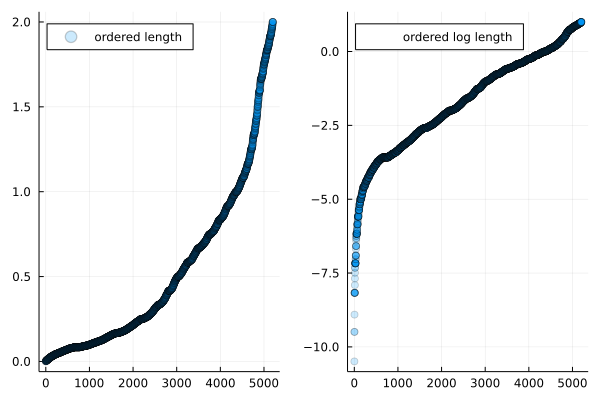

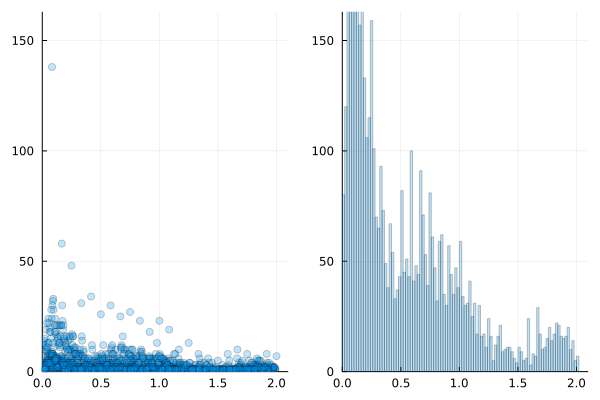

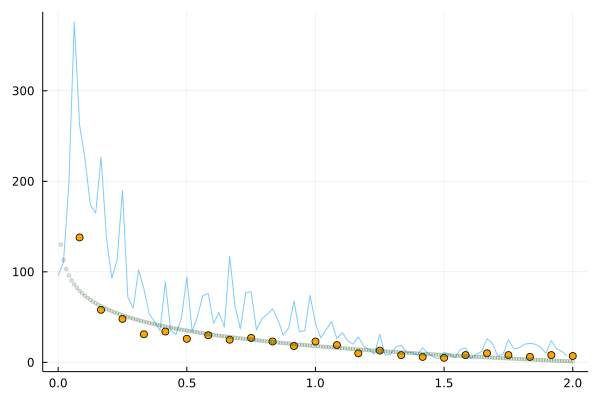

in the bar charts each bar covers:		30 minute(s) as set in settings.
...so there are:				96 slices in graphs i.e. total time div by width of bar.
this many seclusions in total:			6320
only looking at first:				2.0 days
proportion out by then is about:		82%
granularity:					96


In [69]:
#s0 libs

using Combinatorics
using CSV
using DataFrames
using DelimitedFiles
using Distributions
using Plots
using Random
using StatsBase
using Test

#s1 readers

function read_durations()
    output_matrix::Matrix{Float64}  = readdlm("durations.txt", ' ', Float64, '\n')
    durations::Vector{Float64}      = output_matrix[1,:]
    return durations
end

#s2 counters

function count_cumulative_fraction()
    limited::Vector{Float64}    = count_limited()
    durations::Vector{Float64}  = read_durations()
    total::Int64                = length(durations)
    cumulative_fraction::Float64= length(limited)/total
    return cumulative_fraction
end

function count_even_review_durations()
    limit::Float64                          = get_limit()
    minutes::Int64                          = limit*24*60
    width_of_two_hr::Int64                  = get_width_of_two_hr()
    n_two_hr_blocks::Float64                = minutes/width_of_two_hr
    review_range::Vector{Float64}           = collect(1:n_two_hr_blocks)
    even_hours::Vector{Float64}             = [r*2 for r in review_range]
    even_review_durations::Vector{Float64}  = [d/24 for d in even_hours]
    return even_review_durations
end

function count_granularity()
    limit::Float64              = get_limit()
    width_of_hists::Int64       = get_width_of_hists()
    granularity::Int64          = (limit*(24*60))/width_of_hists
    println("granularity:\t\t\t\t\t", granularity)
    return granularity
end

function count_limited()
    durations::Vector{Float64}  = read_durations()
    limit::Float64              = get_limit()
    limited::Vector{Float64}    = [d for d in durations if d<=limit]
    return limited
end

function count_total()
    durations::Vector{Float64}  = read_durations()
    total::Int64                = length(durations)
    return total
end

function count_xs()
    limit::Float64      = get_limit()
    minutes             = limit*24*60
    width_of_hists      = get_width_of_hists()
    n_hists::Int        = minutes/width_of_hists
    xs                  = [float(x) for x in collect(1:n_hists)]
    return xs
end

function interpolate_exponential(θ, this_many_reviews)
    
    println("this many even reviews:\t", this_many_reviews)
    Random.seed!(4579) # Setting the seed if you want similar rands each time - not my cup of tea    
    granularity         = count_granularity()
    
    limited             = count_limited()
    count_durs          = collect(countmap(limited))
    freqs               = [x[2] for x in count_durs]
    max_y               = maximum(freqs)
    
    limit::Float64      = get_limit()
    interpolated_exp    = Exponential(θ)
    noisy_exp           = rand(interpolated_exp, this_many_reviews)
    max_noisy           = maximum(noisy_exp)
    approximate_ys      = [y[2] for y in enumerate(reverse(sort(noisy_exp))) if y[1]<this_many_reviews]
    
    println("only using one random sample to estimate review values - please do it 20 times")
    
    review_xs           = []
    for this_review in 1:this_many_reviews-1
        push!(review_xs,  this_review/12)
    end
    
    return review_xs, approximate_ys
end


function put_dense_between_sparse(sparse, interreview_drop)
    
    limit::Float64              = get_limit()
    sparse_xs::Vector{Float64}  = sparse[1]
    sparse_ys::Vector{Float64}  = sparse[2]
    
    granularity::Int64          = count_granularity()
    dense_xs                    = 1/granularity:1/(granularity*limit):limit
    summed_ys                   = zeros(length(dense_xs))
    for i in 1:length(sparse_xs)
        that_sparse::Tuple{Float64, Float64}    = sparse_xs[i], sparse_ys[i]
        that_x::Float64                         = that_sparse[1]
        that_y::Float64                         = that_sparse[2]
        gap_between_sparses                     = sparse_xs[2] - sparse_xs[1]
        
        dense_ys::Vector{Float64}           = [that_y - that_y*((abs(that_x-x)/
                                            (gap_between_sparses/interreview_drop))) for x in dense_xs]
        zerod_dense_ys::Vector{Float64}     = []
        
        for i in 1:length(dense_ys)
            if dense_ys[i] >= 0
                push!(zerod_dense_ys, dense_ys[i])
            else
                push!(zerod_dense_ys, 0)
            end
        end
        decaying_ys::Vector{Float64}    = [y^2 for y in zerod_dense_ys]
        scaled_ys::Vector{Float64}      = [y/that_y for y in decaying_ys]
        summed_ys::Vector{Float64}      = summed_ys + scaled_ys
    end
    dense::Vector{Vector{Float64}}      = [dense_xs, summed_ys]    
    return dense
end

#s3 drawers

function draw_cont_scat_freqs()
    limited::Vector{Float64}                = count_limited()
    count_durs::Vector{Pair{Float64, Int64}}= collect(countmap(limited))
    durs::Vector{Float64}                   = [x[1] for x in count_durs]
    freqs::Vector{Float64}                  = [x[2] for x in count_durs]
    cont_scat_freqs                         = scatter(durs, freqs, alpha=0.25,
                                              xlims = (0,maximum(durs)+0.1), ylims = (0,maximum(freqs)+25), legend=false)#, 
                                              #label="raw by length", legend=:topright)
    return cont_scat_freqs
end

function draw_hist_freqs()
    limit::Float64                          = get_limit()
    limited::Vector{Float64}                = count_limited()
    count_durs::Vector{Pair{Float64, Int64}}= collect(countmap(limited))
    durs::Vector{Float64}                   = [x[1] for x in count_durs]
    freqs::Vector{Float64}                  = [x[2] for x in count_durs]
    
    width_of_hists::Int64       = get_width_of_hists()
    minutes::Int64              = limit*24*60
    n_hists::Int64              = minutes/width_of_hists
    hist_freqs                  = histogram(limited, bins=n_hists, alpha=0.25, 
                                xlims = (0,maximum(durs)+0.1), ylims = (0,maximum(freqs)+25), legend=false)#,
                                #label="auto bar chart", legend=:topright)
    return hist_freqs
end

function draw_keith_hist()
    limit::Float64              = get_limit()
    limited::Vector{Float64}    = count_limited()
    width_of_hists::Int64       = get_width_of_hists()
    minutes_in_limit::Int64     = limit*24*60
    n_hists_in_limit::Int64     = minutes_in_limit/width_of_hists
    width_of_a_hist_in_days::Float64        = width_of_hists / (24*60) 
    count_durs::Vector{Pair{Float64, Int64}}= collect(countmap(limited))
    durs::Vector{Float64}                   = [x[1] for x in count_durs]
    freqs::Vector{Float64}                  = [x[2] for x in count_durs]
    number_of_counts                        = length(durs)
    @assert number_of_counts == length(durs) == length(freqs)
    
    lumped_freqs = []
    lumped_durs  = []
    
    this_hist_start::Float64 = 0.0
    for i in 1:n_hists_in_limit
        this_hist_end           = this_hist_start + width_of_a_hist_in_days
        all_these_frequencies   = sum([freqs[c] for c in 1:number_of_counts if this_hist_start <= durs[c] < this_hist_end])
        push!(lumped_freqs, all_these_frequencies)
        push!(lumped_durs, this_hist_start)
        this_hist_start         = this_hist_end
    end
    keith_hist                  = plot(lumped_durs, lumped_freqs, markersize=2, alpha=0.5)#,        
                                #xlims = (0,maximum(durs)+0.1), ylims = (0,maximum(freqs)+25), legend=false)#,
                                #label="our bar chart", legend=:right)
    return keith_hist
end

function draw_scat_abs()
    limited::Vector{Float64}    = count_limited()
    orders                      = 1:length(limited)
    scat_abs                    = scatter(orders, limited, alpha=0.2, 
                                label="ordered length", legend=:topleft)
    return scat_abs
end

function draw_scat_logs()
    limited::Vector{Float64}    = count_limited()
    orders                      = 1:length(limited)
    log_abs::Vector{Float64}    = [log2(d) for d in limited]
    scat_logs                   = scatter(orders, log_abs, alpha=0.2, 
                                label="ordered log length", legend=:topleft)
    return scat_logs
end

#s4 plotters

function plot_durationg()
    cont_scat_freqs = draw_cont_scat_freqs()
    hist_freqs      = draw_hist_freqs()
    durationg       = plot(cont_scat_freqs, hist_freqs, layout=(1,2)) # keith_hist      = draw_keith_hist()
    return durationg
end

function plot_orderg()
    # plot all of the durations from shortest to longest
    scat_logs       = draw_scat_logs()
    scat_abs        = draw_scat_abs()
    orderg          = plot(scat_abs, scat_logs, layout=(1,2))
    return orderg
end


function plot_modelg()
    
    keith_hist                     = draw_keith_hist()
    
    even_review_durations          = count_even_review_durations()
    even_review_durations          = [round(d; digits = 4) for d in even_review_durations]
     
    limited                        = count_limited()
    count_durs                     = collect(countmap(limited))
    durs                           = [x[1] for x in count_durs]
    freqs                          = [x[2] for x in count_durs]
    
    even_durs                      = [x[1] for x in count_durs if in(round(x[1], digits = 4), even_review_durations)]
    even_freqs                     = [x[2] for x in count_durs if in(round(x[1], digits = 4), even_review_durations)]
    modelg                         = scatter!(even_durs, even_freqs, alpha=1.0, color="orange", label="even hours", legend=false)
    
    θ                              = params(fit_mle(Exponential, even_freqs))[1]
    granularity::Int64             = count_granularity()
    limit::Float64                 = get_limit() 
    quantile_xs                    = 0:1/(granularity*limit):1
    fitted_exponential             = quantile.(truncated(Exponential(θ),1,Inf), [quantile_xs])
    scaled                         = [y for y in fitted_exponential][1]
    flipped                        = reverse(scaled)
    
    durations                      = read_durations()
    limited_xs                     = [limit*x for x in quantile_xs]
    modelg                         = scatter!(limited_xs, flipped, markersize=2, alpha=0.2)
        
    return modelg
end

# s5 tellers

function tell_config()        
    total::Int64                    = count_total()
    limit::Float64                  = get_limit()
    width_of_hists::Int64           = get_width_of_hists()
    minutes_in_limit::Int64         = limit*24*60
    n_hists_in_limit::Int64         = minutes_in_limit/width_of_hists
    cumulative_fraction::Float64    = count_cumulative_fraction()
    
    println("in the bar charts each bar covers:\t\t", width_of_hists, " minute(s) as set in settings.")
    println("...so there are:\t\t\t\t", n_hists_in_limit, " slices in graphs i.e. total time div by width of bar.")
    println("this many seclusions in total:\t\t\t", total)
    println("only looking at first:\t\t\t\t",limit," days")
    println("proportion out by then is about:\t\t", trunc(Int64,cumulative_fraction*100),"%")
end

#s6 config

function get_interreview_drop()
    interreview_drop                = 7
    return interreview_drop
end

function get_limit()
    limit::Float64                  = 2 # days, conventionally a whole number, or round fractions like 0.5
    return limit
end

function get_width_of_hists()
    width_of_hists::Int64           = 30
    return width_of_hists
end

function get_width_of_two_hr()
    width_of_two_hr::Int64          = 120
    return width_of_two_hr
end


#s6 control

function analyse_seclusion_durations()
    tell_config()
    orderg::Plots.Plot{Plots.GRBackend}     = plot_orderg()
    durationg::Plots.Plot{Plots.GRBackend}  = plot_durationg()
    modelg::Plots.Plot{Plots.GRBackend}     = plot_modelg()
    
    return orderg, durationg, modelg
end                                                   

orderg, durationg, modelg = analyse_seclusion_durations(); # 

display(orderg); display(durationg); display(modelg)

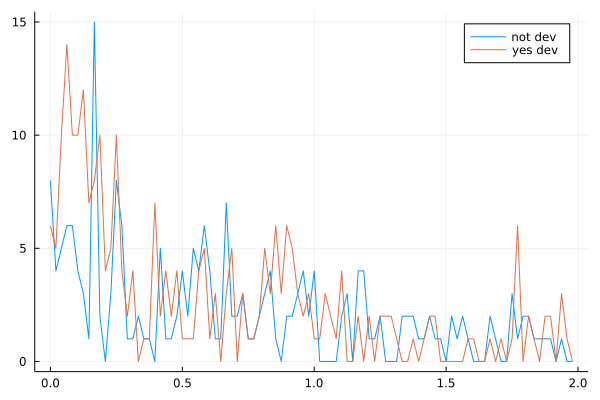

In [70]:
function read_dev_dur_matrix()
    dev_dur_df      = CSV.read("sec_dev_not_dev.csv", DataFrame)
    dev_dur_df      = sort!(dev_dur_df, [:SECLUSION_DURATION])
    developmental   = dev_dur_df.DEVELOPMENTAL
    duration        = dev_dur_df.SECLUSION_DURATION
    dev_dur_matrix  = [[x[1],x[2]] for x in collect(zip(developmental, duration))]
    dev_dur_matrix  = [x for x in dev_dur_matrix if typeof(x[1])!=Missing]
    dev_dur_matrix  = [x for x in dev_dur_matrix if typeof(x[2])!=Missing]
    return dev_dur_matrix
end

function plot_dev_dur_graph()
    
    Random.seed!(4579)
    
    dev_dur_matrix                          = read_dev_dur_matrix()
    limit::Float64                          = get_limit()
    width_of_hists::Int64                   = get_width_of_hists()
    minutes_in_limit::Int64                 = limit*24*60
    n_hists_in_limit::Int64                 = minutes_in_limit/width_of_hists
    width_of_a_hist_in_days::Float64        = width_of_hists / (24*60) 
    
    
    
    not_dev                 = sort([parse(Float64, x[2]) for x in dev_dur_matrix 
                            if x[1]=="No"  && x[2]!="     "])
    yes_dev                 = sort([parse(Float64,x[2]) for x in dev_dur_matrix 
                            if x[1]=="Yes"  && x[2]!="     "])
    
    yes_dev_restraints = length(yes_dev)
    not_dev_restraints = length(not_dev)
    
    if yes_dev_restraints > not_dev_restraints
        just_these_yesses = sample(1:yes_dev_restraints, not_dev_restraints; replace=false, ordered=true)
        yes_dev = yes_dev[just_these_yesses]
    end
    
    if not_dev_restraints > yes_dev_restraints
        just_these_nos = sample(1:not_dev_restraints, yes_dev_restraints; replace=false, ordered=true)
        not_dev = not_dev[just_these_nos]
    end
    
    no_limited::Vector{Float64}             = [d for d in not_dev if d<=limit]
    no_count_durs::Vector{Pair{Float64, Int64}}= collect(countmap(no_limited))
    no_durs::Vector{Float64}                   = [x[1] for x in no_count_durs]
    no_freqs::Vector{Float64}                  = [x[2] for x in no_count_durs]
    no_number_of_counts                        = length(no_durs)
    
    no_lumped_freqs = []
    no_lumped_durs  = []
    
    this_hist_start::Float64 = 0.0
    for i in 1:n_hists_in_limit
        this_hist_end           = this_hist_start + width_of_a_hist_in_days
        all_these_frequencies   = sum([no_freqs[c] for c in 1:no_number_of_counts if this_hist_start <= no_durs[c] < this_hist_end])
        push!(no_lumped_freqs, all_these_frequencies)
        push!(no_lumped_durs, this_hist_start)
        this_hist_start         = this_hist_end
    end
    dev_dur_graph               = plot(no_lumped_durs, no_lumped_freqs, markersize=10, alpha=1, label="not dev")
    

    
    
    yes_limited             = [d for d in yes_dev if d<=limit]
    yes_count_durs          = collect(countmap(yes_limited))
    yes_durs                = [x[1] for x in yes_count_durs]
    yes_freqs               = [x[2] for x in yes_count_durs]
    yes_number_of_counts    = length(yes_durs)
    
    yes_lumped_freqs = []
    yes_lumped_durs  = []
    
    this_hist_start      = 0.0
    for i in 1:n_hists_in_limit
        this_hist_end           = this_hist_start + width_of_a_hist_in_days
        all_these_frequencies   = sum([yes_freqs[c] for c in 1:yes_number_of_counts if this_hist_start <= yes_durs[c] < this_hist_end])
        push!(yes_lumped_freqs, all_these_frequencies)
        push!(yes_lumped_durs, this_hist_start)
        this_hist_start         = this_hist_end
    end
    dev_dur_graph               = plot!(yes_lumped_durs, yes_lumped_freqs, markersize=10, alpha=1, label="yes dev")
    
    return dev_dur_graph
end

dev_dur_graph = plot_dev_dur_graph()

In [60]:
function exp_pdf(x,β)
    y = (1/β)*ℯ^(-x/β)
    return y
end

function demo_exp_pdf()
    limit       = get_limit()
    β           = 1
    xs          = range(0,4,100)
    ys          = map(x -> exp_pdf(x,β),xs)
    exp_pdfg    = scatter(xs, ys, xlims=(0,limit), label="smooth", title="drawing graphs using only beta")
    noisy_pdf   = scatter!(xs, [(y+rand(1)[1]*0.25-0.125) for y in ys], label="noise added")
    return exp_pdfg
end
#exponential_probability_distribution_function = demo_exp_pdf()
#display(exponential_probability_distribution_function)

demo_exp_pdf (generic function with 1 method)

In [61]:
# s9 tests

function test_count_cumulative_fraction()
    cumulative_fraction = count_cumulative_fraction()
    @test typeof(cumulative_fraction) == Float64
    @test -0.01 < cumulative_fraction <= 1.0
    println("passed count cumulative fraction")
end

function test_count_xs()
    xs              = count_xs()
    limit           = get_limit()
    minutes         = limit*24*60
    width_of_hists  = get_width_of_hists()
    n_hists::Int    = minutes/width_of_hists
    @test length(xs) == n_hists
    println("passed get_xs")
end

function test_count_even_review_durations()
    even_review_durations  = count_even_review_durations()
    @test typeof(even_review_durations) == Vector{Float64}
    @test mean(.>(even_review_durations, 0))==1.0
    println("passed get_even_review_durations")
end

function test_my_poisson()
    xs            = collect(1:20) 
    labda         = 4
    my_scores     = dist_poisson(xs, labda)
    their_pdf     = Poisson(labda)
    their_scores  = [pdf(their_pdf,x) for x in xs]
    @test isapprox(my_scores,their_scores; atol = 1.0e-12)
    println("passed my_poisson")
end

function my_poisson(k, labda)    
    probability = (labda^k)*(ℯ^(-labda))/factorial(big(k))
    return probability
end

function dist_poisson(xs, labda)
    xs              = [trunc(Int64,x) for x in xs]
    ys              = [my_poisson(x, labda) for x in xs]
    return ys
end

function harry_tests()
    test_count_cumulative_fraction()
    test_count_even_review_durations()
    test_my_poisson()
    test_count_xs()
    #test_put_dense_between_sparse()
    println("passed all tests")
end

harry_tests()

passed count cumulative fraction
passed get_even_review_durations
passed my_poisson
passed get_xs
passed all tests


granularity:					12


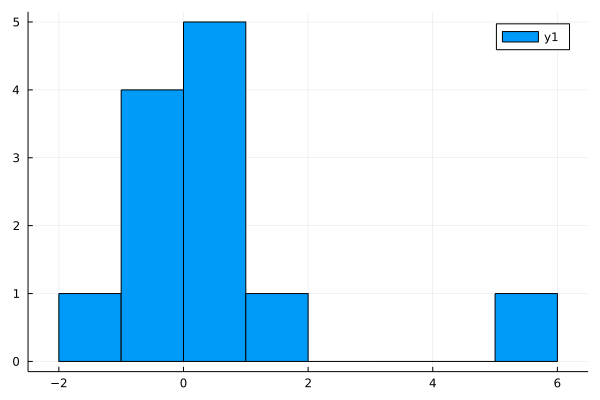

In [62]:
granularity                         = count_granularity()
limit                               = get_limit() 
quantile_xs                         = 1/granularity:1/(granularity*limit):1
fitted_normal                       = quantile.(truncated(Normal(),-5,5), [quantile_xs])
histogram(quantile_xs, fitted_normal)